# Histopathologic Cancer Detection
## Project Overview
The goal of this project is to identify metastatic cancer in small image patches taken from larger digital pathology scans.  There are over 220,000 training images and over 50,000 test images.  All of the images are fairly small (96x96) and contained in the Kaggle input folders.  Correct labels for the training images have been provided in a comma-separated values (.csv) file. 
# Source
This project is a Kaggle competition that can be found here https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview

In [1]:
# Load lots of libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import PIL.Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.metrics import AUC
print("Tensorflow version:", tf.__version__)


2024-03-30 19:10:08.449372: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 19:10:08.449501: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 19:10:08.569697: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version: 2.15.0


In [2]:
# Load the training data and labels.  Get information about the files in the directories.
core_path = '/kaggle/input/histopathologic-cancer-detection/'
test_path = core_path + 'test/'
train_path = core_path + 'train/'
df_train_labels = pd.read_csv(core_path + "train_labels.csv")
df_test_labels = pd.read_csv(core_path + "sample_submission.csv")
print("Training data frame:\n", df_train_labels.head())
num_train_images = len(df_train_labels)
num_train_image_files = len(os.listdir(train_path))
num_test_images = len(os.listdir(test_path))
print("Number training images:", num_train_images)
print("Number training image files:", num_train_image_files)
print("Number test images:    ", num_test_images)

# Get a list of all of the names of the files in the directories
train_images_dir_filenames = os.listdir(train_path)
test_images_dir_filenames = os.listdir(test_path)
print("A sample of the training images filenames in the directory:\n", train_images_dir_filenames[:4])
print("A sample of the test images filenames in the directory:\n", test_images_dir_filenames[:4])

# Save off the filename for each ID as a new column
df_train_labels['filename'] = df_train_labels['id'] + '.tif'


Training data frame:
                                          id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Number training images: 220025
Number training image files: 220025
Number test images:     57458
A sample of the training images filenames in the directory:
 ['d43c081bafa286f9c1f7e921883f26ceafebc912.tif', '092d0eedebce504847715ee046b6ad74b57599b4.tif', 'b0d2582c6218a8764323fc940b41312282b99bf4.tif', '187c99df762f13f99818e5593d4bab4c6577e7e3.tif']
A sample of the test images filenames in the directory:
 ['a7ea26360815d8492433b14cd8318607bcf99d9e.tif', '59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif', '5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif', 'bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif']


## Basic Exploratory Data Analysis
The data provided by the Kaggle competition has already been cleaned, so there isn't much work requried.  There are no missing values (IDs, labels) in the training set.  All of the labels are either 0 or 1.  There are over 220,000 training images of which about 40% are tumor positive.

Number of empty cells: 0
All possible values for training labels: {0, 1}
label
0    130908
1     89117
Name: count, dtype: int64
label
0    0.594969
1    0.405031
Name: proportion, dtype: float64
Number of training images that are tumor postive: 89117
Number of training images that are tumor negative: 130908


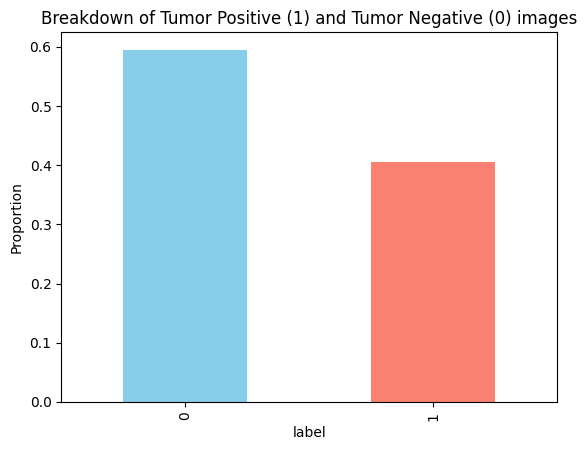

In [3]:
# Check if there are any missing values (IDs or labels)
numNaNs = df_train_labels.isna().sum().sum()  # Count the total number of NaNs across all columns
print("Number of empty cells:", numNaNs)

print("All possible values for training labels:", set(df_train_labels['label']))
print(df_train_labels['label'].value_counts())
print(df_train_labels['label'].value_counts(normalize=True))
#df_train_labels['label'].plot(kind='hist', density=True)
df_train_labels['label'].value_counts(normalize=True).plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Breakdown of Tumor Positive (1) and Tumor Negative (0) images')
plt.ylabel('Proportion')
num_train_is_tumor = len(df_train_labels[df_train_labels['label'] == 1])
print("Number of training images that are tumor postive:", num_train_is_tumor)
print("Number of training images that are tumor negative:", num_train_images-num_train_is_tumor)

## View single image
The following is an example of one of the many images that have been provided.  Note that the images are 96x96 pixels and 3-channel (RGB).

Image Shape = (96, 96, 3)
87832    0
Name: label, dtype: int64


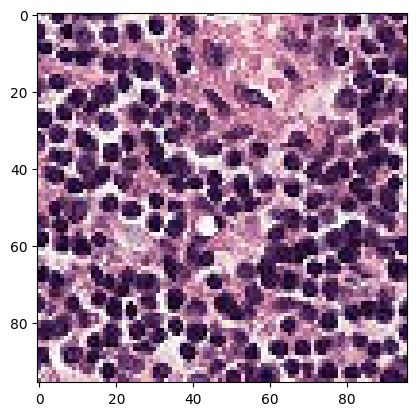

In [4]:
# Display a single image and its properties
singleImage_path = "/kaggle/input/histopathologic-cancer-detection/train/00004aab08381d25d315384d646f5ce413ea24b1.tif"
singleImage = PIL.Image.open(singleImage_path)
singleImage_array = np.array(singleImage)
print(f"Image Shape = {singleImage_array.shape}")
print(df_train_labels[df_train_labels['id'] == '00004aab08381d25d315384d646f5ce413ea24b1']['label'])
#print("Presence of tumor:", "True" if df_train_labels[df_train_labels['id'] == '00004aab08381d25d315384d646f5ce413ea24b1']['label'] == 1 else "False")
plt.imshow(singleImage)
plt.show()

## Grid of tumor positive and tumor negative images
The following graphics shows three images that are tumor positive, and three that are tumor negative.  It's hard to see any difference among them.

Image mode: RGB


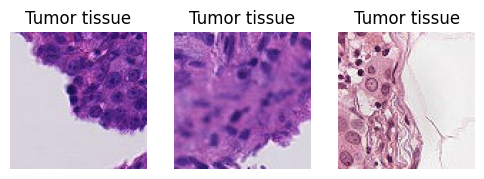

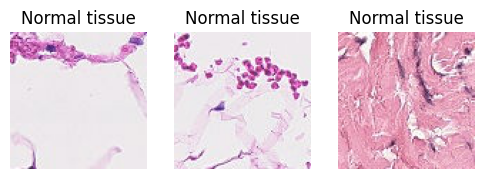

In [53]:
# Sort the training data according to the ID so that it is in the same order as the files in the 
#   training directory.
#df_train_labels.sort_values(by='id', inplace=True)
# Display some of the images - three each of the tumor positive and negative
numToDisplay = 3
sample_tumorPos_ids = df_train_labels[df_train_labels['label'] == 1]['id'].sample(n=numToDisplay).values
sample_tumorNeg_ids = df_train_labels[df_train_labels['label'] == 0]['id'].sample(n=numToDisplay).values

tumorPos_images = []
for id in sample_tumorPos_ids:
    image_path = os.path.join(train_path, id + '.tif')  
    tumorPos_images.append(PIL.Image.open(image_path))
    
tumorNeg_images = []
for id in sample_tumorNeg_ids:
    image_path = os.path.join(train_path, id + '.tif') 
    tumorNeg_images.append(PIL.Image.open(image_path))

print("Image mode:", tumorPos_images[1].mode)
plt.figure(figsize=(6, 3))
for i, image in enumerate(tumorPos_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title('Tumor tissue')
    plt.axis('off')
plt.show()

plt.figure(figsize=(6, 3))
for i, image in enumerate(tumorNeg_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title('Normal tissue')
    plt.axis('off')
plt.show()

# Analysis Strategy and Data Preparation
## Strategy
Based on the structure of the input data, the strategy for classification is to split the training data into a training and validation set.  Then create a few convolution network models to train on the training data and validate with the validation data.  Once a reasonable model is achieved, it will be used to predict the labels for the test data.

## Create Sample of Training Data
Since there are over 220,000 images in the training set, a random sample will be generated and used in the model training.  To ensure that the balance between tumor positive and tumor negative labels is maintained, a set of 10 samples of 22,000 images is generated and the label proportion compared to the 40% in the full set.  The result is that each of the samples is very close to 40%.
The training and evaluation was done iteratively with 10%, 20%, and 100% of the total training data.

In [40]:
# Create randomized samples from the full training data set.
sampleFrac = 0.2
sampleLen = len(df_train_labels) * sampleFrac
props = np.zeros(10)
for i in range(10):
    df_train_sample = df_train_labels.sample(frac=sampleFrac, replace=False)
    props[i] = df_train_sample[(df_train_sample['label'] == 1)].shape[0] / sampleLen
print(props)
print(df_train_sample.shape[0])

[0.4018407  0.40409044 0.40338598 0.40613567 0.40263606 0.40586297
 0.4069992  0.40452221 0.40434042 0.40790819]
44005


In [41]:
# Convert the labels to type string for the ImageDataGenerator
df_train_sample["label"] = df_train_sample["label"].astype(str)

batchSize_train = batchSize_val = batchSize_test = 32
targetSize = (96,96)

## Data Set Generation
The ImageDataGenerator was used to generate the datasets even though it is now deprecated.  The recommended approach using Tensorflow 2 is to use image_dataset_from_directory.  However, this new method was not used.  The training images are in a single folder and the labels are in a data frame.  The image_dataset_from_directory API is supposed to allow for this but I couldn't get it to work.

An 80/20 split of the training data was established so that there is a separate validation set.  This was done through the ImageDataGenerator instead of sklearn's train_test_split as it seemed to run much faster this way.

Several configurations were tried with ImageDataGenerator that included or left off the rotation_range, width_shift_range, etc.  There was no effect on model performance with regard to these various configurations. 

In [42]:
# Create the data generator for the training images by combining the images
#   in the train directory with the labels in the train_labels.csv.  Establish an
#   80/20 training / validation set split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_dataframe(
    dataframe=df_train_sample,
    directory = train_path,
    x_col = 'filename',
    y_col = 'label',
    target_size=targetSize,
    color_mode = "rgb",
    batch_size=batchSize_train,
    class_mode='binary',
    subset='training',
    shuffle = True,
    validate_filenames = False,
    seed = 1243
)

val_generator = datagen.flow_from_dataframe(
    dataframe=df_train_sample,
    directory = train_path,
    x_col = "filename",
    y_col = "label",
    target_size = targetSize,
    color_mode = "rgb",
    batch_size = batchSize_val,
    class_mode = "binary",
    subset = "validation",
    shuffle = True,
    validate_filenames = False,
    seed = 1243
)

train_steps = (sampleLen * (1-sampleFrac)) // batchSize_train
val_steps = (sampleLen * sampleFrac) // batchSize_train

Found 35204 non-validated image filenames belonging to 2 classes.
Found 8801 non-validated image filenames belonging to 2 classes.


In [43]:
# Create the data generator for the test images by combining the images
#   in the test directory with the labels in the sample_submission.csv file.
#   Note that the 'label' column here is essentially irrelevant
df_test_labels['filename'] = df_test_labels['id'] + '.tif'
df_test_labels["label"] = df_test_labels["label"].astype(str)

test_generator = datagen.flow_from_dataframe(
    dataframe = df_test_labels,
    directory = test_path,
    x_col = "filename",
    y_col = None,
    target_size = (96, 96),
    color_mode = "rgb",
    batch_size = batchSize_test,
    shuffle = False,
    class_mode = None,
    validate_filenames = False,
    seed = 1243
)

Found 57458 non-validated image filenames.


# Model Architecture
A few simple, "standard" architectures were tried, all with similar results.  Regardless of the model, the accuracy and AUC for the training, validation, and test data were all close to 50%.  Note that a 50% accuracy is equivalent to pure guessing.  Given these results, obviously something is fundamentally wrong with the code here.
All of the models were a variation on combinations of blocks of [conv-layer / conv-layer / pool-layer].  Each of the three models uses Batch Normalization after each stack of convolutional layers in addition to a 2x2 Max Pooling layer.

In [44]:
# Define the CNN function
def CNN(model):
    model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(96,96,3)))
    #model.add(layers.Conv2D(16, (3,3), activation='relu', tf.Input(input_shape=(96,96,3))))
    model.add(layers.Conv2D(16, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    # Batch normalization
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    # Batch normalization
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    # Convert to 1D vector
    model.add(layers.Flatten())

    # Classification layers
    model.add(layers.Dense(64, activation='sigmoid'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [45]:
def CNN2(model):
    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    # Fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification    
    return model

In [ ]:
def CNN3(model):
    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    # Fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification    
    return model

The three different models were also trained with two optimizers: Adam and RSM.

In [46]:
# Adam with CNN
# Suppress unnecessary warnings so that the presentation looks clean
import warnings
warnings.filterwarnings("ignore")

train_on_gpu = True
use_Adam_model = True
if use_Adam_model:
    Adam_model = CNN(tf.keras.Sequential())
    Adam_model.compile(
        #optimizer = 'adam',
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005),
        loss = 'binary_crossentropy',
        metrics = [AUC(), 'accuracy']
    )

    Adam_history = Adam_model.fit(
        train_generator,
        validation_data = val_generator,
        steps_per_epoch=train_steps,
        validation_steps=val_steps,
        epochs = 6
    )


Epoch 1/6
   1/1101 ━━━━━━━━━━━━━━━━━━━━ 2:39:42 9s/step - auc_2: 0.3906 - loss: 0.8807

W0000 00:00:1711828477.174990      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1085/1101 ━━━━━━━━━━━━━━━━━━━━ 4s 305ms/step - auc_2: 0.8181 - loss: 0.5104

2024-03-30 20:00:09.270880: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 7.86503, expected 6.88267
2024-03-30 20:00:09.270934: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 7.88365, expected 6.90129
2024-03-30 20:00:09.270946: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 8.00956, expected 7.0272
2024-03-30 20:00:09.270954: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 7.73323, expected 6.75087
2024-03-30 20:00:09.270962: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.48802, expected 5.50566
2024-03-30 20:00:09.270970: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 8.03519, expected 7.05283
2024-03-30 20:00:09.270977: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 7.59692, expected 6.61456
2024-03-30 20:00:09.270985: E external/local_xla/xla/ser

1086/1101 ━━━━━━━━━━━━━━━━━━━━ 4s 310ms/step - auc_2: 0.8181 - loss: 0.5104

W0000 00:00:1711828813.022145      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1100/1101 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - auc_2: 0.8184 - loss: 0.5099

W0000 00:00:1711828816.114977      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-03-30 20:01:40.991351: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8845: 5.19126, expected 4.55948
2024-03-30 20:01:40.991399: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8846: 5.23895, expected 4.60718
2024-03-30 20:01:40.991410: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8882: 4.9463, expected 4.31452
2024-03-30 20:01:40.991417: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8896: 5.24628, expected 4.6145
2024-03-30 20:01:40.991425: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8898: 4.20186, expected 3.57009
2024-03-30 20:01:40.991440: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8909: 4.91446, expected 4.28268
2024-03-30 20:01:40.991448: E external/local_xla/

1101/1101 ━━━━━━━━━━━━━━━━━━━━ 433s 386ms/step - auc_2: 0.8185 - loss: 0.5099 - val_auc_2: 0.7255 - val_loss: 0.6654
Epoch 2/6
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 151s 136ms/step - auc_2: 0.8688 - loss: 0.4404 - val_auc_2: 0.8631 - val_loss: 0.5485
Epoch 3/6
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 151s 136ms/step - auc_2: 0.8836 - loss: 0.4172 - val_auc_2: 0.8811 - val_loss: 0.4365
Epoch 4/6
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 150s 136ms/step - auc_2: 0.8892 - loss: 0.4089 - val_auc_2: 0.8871 - val_loss: 0.4717
Epoch 5/6
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 150s 135ms/step - auc_2: 0.8949 - loss: 0.4001 - val_auc_2: 0.9074 - val_loss: 0.3983
Epoch 6/6
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 150s 136ms/step - auc_2: 0.8974 - loss: 0.3925 - val_auc_2: 0.8976 - val_loss: 0.4235


In [ ]:
use_Adam_model2 = False
if use_Adam_model2:
    Adam_model2 = CNN2(tf.keras.Sequential())
    Adam_model2.compile(
        #optimizer = 'adam',
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005),
        loss = 'binary_crossentropy',
        metrics = [AUC(), 'accuracy']
    )

    Adam_history2 = Adam_model2.fit(
        train_generator,
        validation_data = val_generator,
        epochs = 6
    )

## Results and Analysis
The accuracy, precision, recall, F1, and AUC were calculated for the training and validation data.  Again, the accuracy is around 50% meaning that it is random guessing.

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
def evaluate_model(preds, useVal = True):
    #print("preds shape", preds.shape)
    pred_classes = np.round(preds.flatten()).astype('int')
    #print("classes shape", pred_classes.shape)
    #print("preds:", preds[:40].tolist())
    #print("val_pred_classes:", pred_classes[:40])

    # True labels
    true_labels = val_generator.classes if (useVal == True) else train_generator.classes
    
    # Ensure the lengths match
    pred_classes = pred_classes[:len(true_labels)]

    # Calculate metrics
    accuracy = accuracy_score(true_labels, pred_classes)
    precision = precision_score(true_labels, pred_classes)
    recall = recall_score(true_labels, pred_classes)
    f1 = f1_score(true_labels, pred_classes)
    #roc_auc = roc_auc_score(true_labels, val_predictions)
    roc_auc = roc_auc_score(true_labels, preds)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

In [48]:
preds_Adam = Adam_model.predict(val_generator)

276/276 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step


In [49]:
evaluate_model(preds_Adam, True)  # Examine performance against validation data
preds_Adam_train = Adam_model.predict(train_generator)
evaluate_model(preds_Adam_train, False) # Examine performance against training data

preds shape (8801, 1)
classes shape (8801,)
preds: [[0.45274439454078674], [0.044181473553180695], [0.6232735514640808], [0.16710709035396576], [0.06879892945289612], [0.6051698923110962], [0.9687124490737915], [0.6167520880699158], [0.9246224761009216], [0.9625842571258545], [0.08946336060762405], [0.9682687520980835], [0.052860092371702194], [0.9702352285385132], [0.08452212065458298], [0.20167674124240875], [0.07662296295166016], [0.037865620106458664], [0.07972696423530579], [0.9702469706535339], [0.9702469706535339], [0.06802627444267273], [0.025109203532338142], [0.34573954343795776], [0.9702469706535339], [0.9702469706535339], [0.3944902718067169], [0.011628899723291397], [0.9693509340286255], [0.03140055015683174], [0.9694627523422241], [0.08573649823665619], [0.9163604974746704], [0.2877631187438965], [0.7666678428649902], [0.96964031457901], [0.9338353872299194], [0.0876694843173027], [0.023676685988903046], [0.07927582412958145]]
val_pred_classes: [0 0 1 0 0 1 1 1 1 1 0 1 0 

In [50]:
def graph_model_epoch_performance(run_history, title=''):
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    fig.tight_layout()
    fig.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.plot(run_history.history['loss'], label='Loss')
    plt.plot(run_history.history['val_loss'], label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Validation Loss Per Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(run_history.history['auc'], label='Training AUC')
    plt.plot(run_history.history['val_auc'], label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    plt.subplots_adjust(wspace=0.2)
    plt.show()

In the following graphs, it appears that the model is learning well with the training and validation AUC reaching near 90%.  However, submission of predictions for the test data gives a score of 0.49.

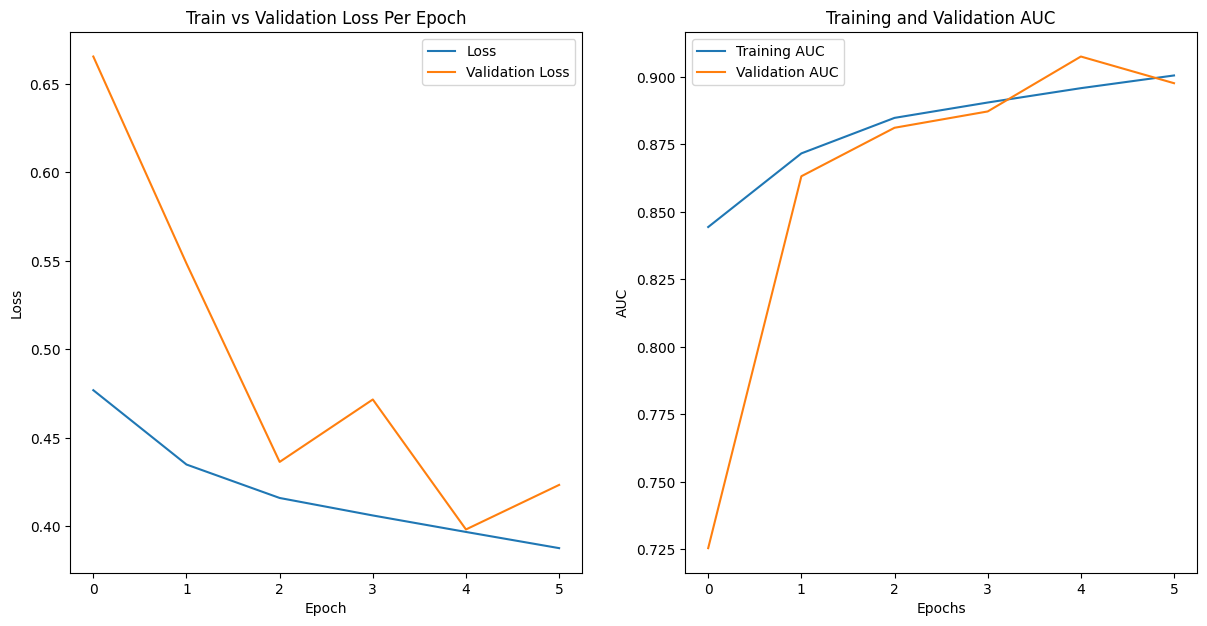

In [51]:
Adam_history.history.keys()
Adam_history.history['auc'] = Adam_history.history.pop('auc_2')
Adam_history.history['val_auc'] = Adam_history.history.pop('val_auc_2')
graph_model_epoch_performance(Adam_history)

In [52]:
test_path = "/kaggle/input/histopathologic-cancer-detection/test"
test_ids = [filename[:-4] for filename in os.listdir(test_path)]

test_probs = Adam_model.predict(test_generator)
test_labels = np.round(test_probs).astype(int).flatten()
out_df = pd.DataFrame()
out_df["id"] = test_ids
out_df["label"] = test_labels
out_df.to_csv(os.path.join('/kaggle/working/', "test_labels.csv"), index=False)

2024-03-30 20:23:33.880113: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 26510: 7.17802, expected 6.31667
2024-03-30 20:23:33.880167: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 26511: 7.38327, expected 6.52192
2024-03-30 20:23:33.880183: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 26512: 7.06976, expected 6.20841
2024-03-30 20:23:33.880197: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 26516: 7.27634, expected 6.41499
2024-03-30 20:23:33.880208: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 26517: 7.30416, expected 6.44282
2024-03-30 20:23:33.880218: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 26518: 7.05719, expected 6.19584
2024-03-30 20:23:33.880229: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 26520: 7.13792, expected 6.27657
2024-03-30 20:23:33.880239:

897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step

2024-03-30 20:34:41.521063: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10380: 4.24501, expected 3.72037
2024-03-30 20:34:41.521119: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12266: 4.18795, expected 3.66332
2024-03-30 20:34:41.521186: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 26508: 6.28583, expected 5.31318
2024-03-30 20:34:41.521194: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 26509: 7.21813, expected 6.24548
2024-03-30 20:34:41.521202: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 26510: 7.07519, expected 6.10254
2024-03-30 20:34:41.521210: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 26511: 5.58039, expected 4.60774
2024-03-30 20:34:41.521218: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 26512: 6.70869, expected 5.73604
2024-03-30 20:34:41.521225:

898/898 ━━━━━━━━━━━━━━━━━━━━ 669s 744ms/step


# Conclusion
I was very disappointed that I couldn't get the dataset, model, and/or predictions to work right.  After dozens of hours spent trying various approaches and models, I had to move on.

In [ ]:
#####################################################################################
#####################################################################################
#####################################################################################
#####################################################################################
#####################################################################################
#####################################################################################
#####################################################################################

In [26]:
train_on_gpu = True
use_RMS_model = False
if use_RMS_model == True:
    RMS_model = CNN(tf.keras.Sequential())
    #print(RMS_model.summary())

    RMS_model.compile(
        optimizer = 'RMSprop',
        loss = 'binary_crossentropy',
        metrics = [AUC()]
    )

    RMS_history = RMS_model.fit(
        train_generator,
        validation_data = val_generator,
        epochs = 6
    )

    prediction_labels_RMS = RMS_model.predict(test_generator)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/6


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   1/5501 ━━━━━━━━━━━━━━━━━━━━ 18:40:53 12s/step - auc: 0.4500 - loss: 0.8358

I0000 00:00:1711731956.506454      93 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2048s 370ms/step - auc: 0.8612 - loss: 0.4509 - val_auc: 0.8675 - val_loss: 0.7629
Epoch 2/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 854s 155ms/step - auc: 0.9188 - loss: 0.3520 - val_auc: 0.7520 - val_loss: 1.1020
Epoch 3/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 828s 150ms/step - auc: 0.9313 - loss: 0.3247 - val_auc: 0.9148 - val_loss: 0.5632
Epoch 4/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 846s 154ms/step - auc: 0.9387 - loss: 0.3072 - val_auc: 0.9251 - val_loss: 0.3491
Epoch 5/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 850s 154ms/step - auc: 0.9414 - loss: 0.3006 - val_auc: 0.9345 - val_loss: 0.3593
Epoch 6/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 812s 147ms/step - auc: 0.9455 - loss: 0.2891 - val_auc: 0.8985 - val_loss: 0.5668
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 521s 290ms/step


In [54]:
if use_RMS_model == True:
    prediction_labels_RMS = prediction_labels_1
    prediction_labels_RMS.shape

(57458, 1)

In [51]:
if use_RMS_model == True:
    model_pred_df_RMS = pd.DataFrame(columns=['id', 'label'])
    test_images_filenames = sorted(test_images_filenames)

    # Take a quick look
    model_pred_df_RMS['id'] = [filename.split('.')[0] for filename in test_images_filenames]
    model_pred_df_RMS['label'] = np.round(prediction_labels_RMS.flatten()).astype('int')
    model_pred_df_RMS

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0
1,0000ec92553fda4ce39889f9226ace43cae3364e,0
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0
...,...,...
57453,fffdd1cbb1ac0800f65309f344dd15e9331e1c53,0
57454,fffdf4b82ba01f9cae88b9fa45be103344d9f6e3,1
57455,fffec7da56b54258038b0d382b3d55010eceb9d7,0
57456,ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6,0


In [52]:
if use_RMS_model == True:
    model_pred_df_RMS.to_csv(os.path.join('/kaggle/working/', "RMS_test_labels.csv"), index=False)

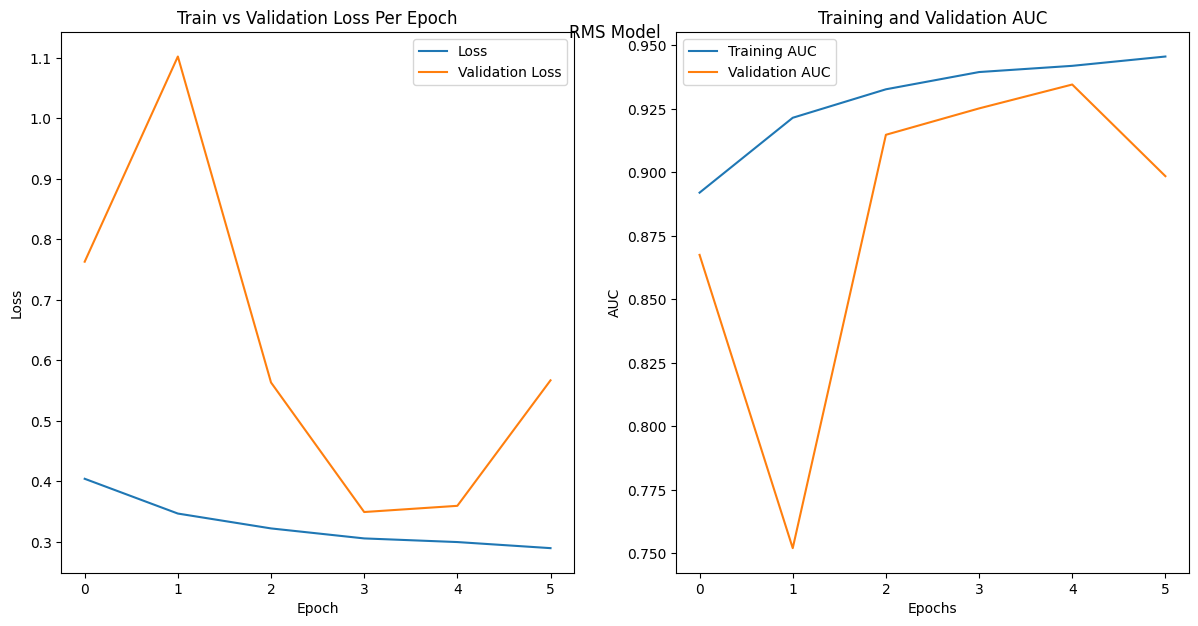

In [40]:
if use_RMS_model == True:
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    fig.tight_layout()
    fig.suptitle('RMS Model')
    plt.subplot(1, 2, 1)
    plt.plot(RMS_history.history['loss'], label='Loss')
    plt.plot(RMS_history.history['val_loss'], label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Validation Loss Per Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(RMS_history.history['auc'], label='Training AUC')
    plt.plot(RMS_history.history['val_auc'], label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    plt.subplots_adjust(wspace=0.2)
    plt.show()
